# Magnetic Dipole Approximation Demo

This demo verifies the magnetic dipole approximation. It compares the magnetic field from a small, circular current loop at a large distance with the analytical formula for a magnetic dipole.

The key verification is to show that the error between the numerically computed field from the loop and the analytical dipole field decreases as the distance from the loop increases. We expect the error to fall off, and we will visualize this relationship with a plot.

In [1]:
import numpy as np
from mtflib import *
from applications.em.biot_savart import serial_biot_savart
from applications.em.current_ring import current_ring
from mtflib.taylor_function import MultivariateTaylorFunctionBase
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Global MTF Settings ---
initialize_mtf_globals(max_order=3, max_dimension=4)
set_global_etol(1e-12)

# --- Define Variables for MTF ---
x = Var(1)
y = Var(2)
z = Var(3)

Initializing MTF globals with: _GLOBAL_MAX_ORDER=3, _GLOBAL_MAX_DIMENSION=4
Loading/Precomputing Taylor coefficients up to order 3
Global precomputed coefficients loading/generation complete.
Size of precomputed_coefficients dictionary in memory: 464 bytes, 0.45 KB, 0.00 MB
MTF globals initialized: _GLOBAL_MAX_ORDER=3, _GLOBAL_MAX_DIMENSION=4, _INITIALIZED=True
Max coefficient count (order=3, nvars=4): 35
Precomputed coefficients loaded and ready for use.


### 1. Visualize the Geometry

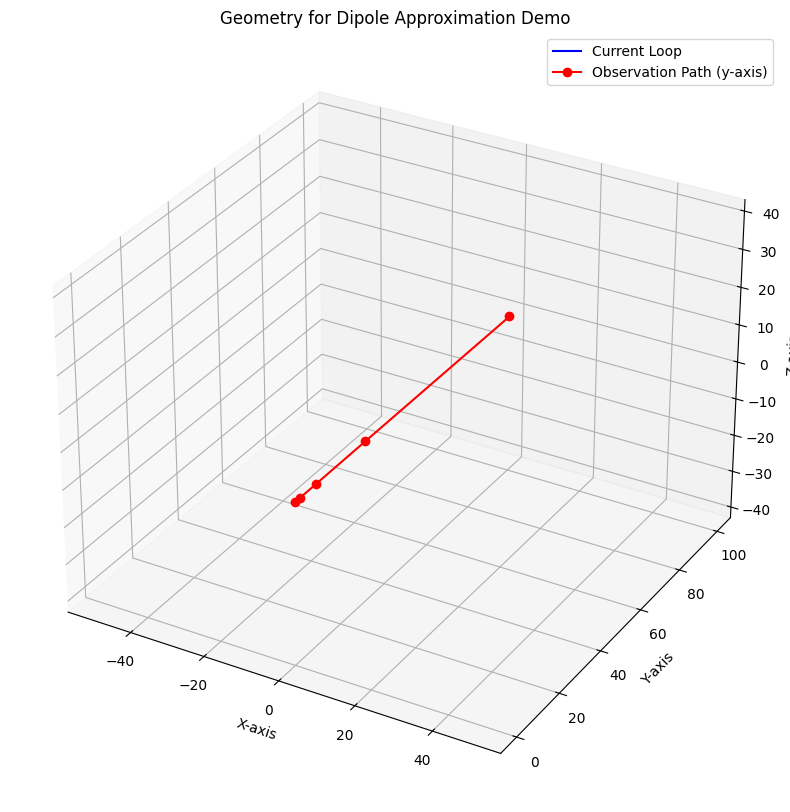

In [2]:
# --- Define loop parameters for visualization ---
ring_radius = 0.01
ring_center_point = np.array([0.0, 0.0, 0.0])
distances_to_plot = np.logspace(0, 2, 5) # Show a few observation points

# --- Generate points for the current loop ---
theta = np.linspace(0, 2 * np.pi, 100)
loop_x = ring_center_point[0] + ring_radius * np.cos(theta)
loop_y = ring_center_point[1] + ring_radius * np.sin(theta)
loop_z = np.full_like(loop_x, ring_center_point[2])

# --- Visualize the Setup ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(loop_x, loop_y, loop_z, 'b-', label='Current Loop')
# Add an arrow for current direction
ax.quiver(ring_radius, 0, 0, 0, 1, 0, length=0.01, normalize=True, color='b', arrow_length_ratio=0.4)

# Plot the line along which the field is evaluated
obs_x = np.zeros_like(distances_to_plot)
obs_y = distances_to_plot
obs_z = np.zeros_like(distances_to_plot)
ax.plot(obs_x, obs_y, obs_z, 'r-o', label='Observation Path (y-axis)')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Geometry for Dipole Approximation Demo')
ax.legend()
ax.axis('equal')
plt.show()

### 2. Function to Calculate Approximation Error

In [3]:
def calculate_error_at_distance(distance):
    # Define a small current loop
    ring_radius = 0.01
    num_segments_ring = 20
    current = 1.0
    ring_center_point = np.array([0.0, 0.0, 0.0])
    ring_axis_direction = np.array([0, 0, 1])

    segment_mtfs, element_lengths, direction_vectors = current_ring(
        ring_radius, num_segments_ring, ring_center_point, ring_axis_direction)

    # Define a far-field point for expansion
    field_point_mtf = np.array([[x, y + distance, z]], dtype=object)

    # Calculate the B-field from the loop (Numerical)
    B_numerical_mtf_with_u = serial_biot_savart(segment_mtfs, element_lengths, direction_vectors, field_point_mtf)
    B_numerical_mtf = [integrate(bfld, 4, -1, 1) for bfld in B_numerical_mtf_with_u[0]]

    # Calculate the B-field from the analytical dipole formula
    mu_0_4pi = 1e-7
    area = math.pi * ring_radius**2
    m_vec = np.array([0, 0, current * area])
    m_mtf = np.array([MultivariateTaylorFunctionBase.from_constant(c) for c in m_vec], dtype=object)
    r_mtf = np.array([x, y + distance, z], dtype=object)
    r_squared_mtf = r_mtf[0]**2 + r_mtf[1]**2 + r_mtf[2]**2
    r_mag_mtf = sqrt_taylor(r_squared_mtf)
    m_dot_r_mtf = m_mtf[0]*r_mtf[0] + m_mtf[1]*r_mtf[1] + m_mtf[2]*r_mtf[2]
    term1_scalar_inv_r5 = 3 * m_dot_r_mtf / (r_mag_mtf**5)
    term1 = [c * term1_scalar_inv_r5 for c in r_mtf]
    term2_scalar_inv_r3 = 1 / (r_mag_mtf**3)
    term2 = [c * term2_scalar_inv_r3 for c in m_mtf]
    B_analytic_mtf = [mu_0_4pi * (t1 - t2) for t1, t2 in zip(term1, term2)]

    # Calculate the error (norm of the difference of the constant terms)
    B_num_const = np.array([c.extract_coefficient((0,0,0,0)) for c in B_numerical_mtf])
    B_an_const = np.array([c.extract_coefficient((0,0,0,0)) for c in B_analytic_mtf])
    error = np.linalg.norm(B_num_const - B_an_const)
    return error

### 3. Run Simulation Over a Range of Distances

In [4]:
distances = np.logspace(0, 2, 20) # from 1m to 100m
errors = []
for d in distances:
    error = calculate_error_at_distance(d)
    print(f"Distance: {d:.2f}, Error: {error:.2e}")
    errors.append(error)

Distance: 1.00, Error: 3.53e-15


Distance: 1.27, Error: 1.05e-15


Distance: 1.62, Error: 3.13e-16


Distance: 2.07, Error: 9.32e-17


Distance: 2.64, Error: 1.71e-12


Distance: 3.36, Error: 8.28e-13


Distance: 4.28, Error: 4.00e-13


Distance: 5.46, Error: 1.93e-13


Distance: 6.95, Error: 9.35e-14


Distance: 8.86, Error: 4.52e-14


Distance: 11.29, Error: 2.18e-14


Distance: 14.38, Error: 1.06e-14


Distance: 18.33, Error: 5.10e-15


Distance: 23.36, Error: 2.47e-15


Distance: 29.76, Error: 1.19e-15


Distance: 37.93, Error: 5.76e-16


Distance: 48.33, Error: 2.78e-16


Distance: 61.58, Error: 1.35e-16


Distance: 78.48, Error: 6.50e-17


Distance: 100.00, Error: 3.14e-17


### 4. Plot Error vs. Distance

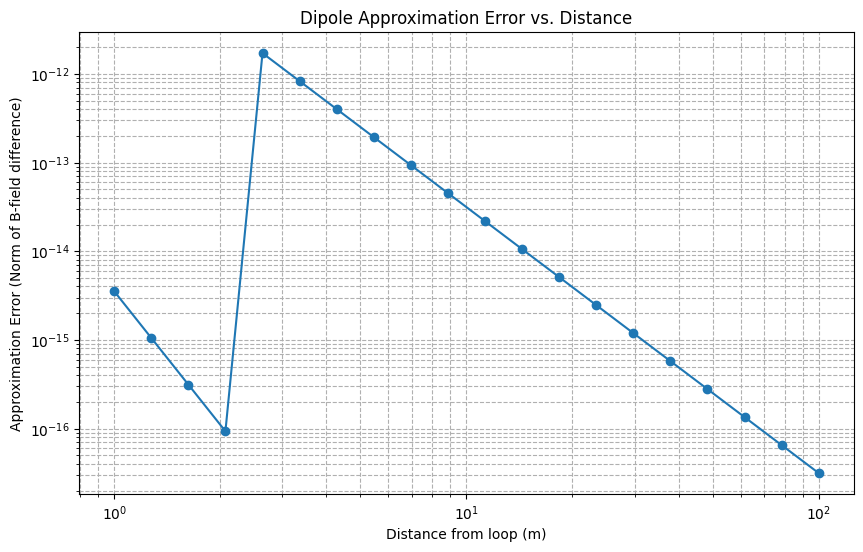

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(distances, errors, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance from loop (m)')
plt.ylabel('Approximation Error (Norm of B-field difference)')
plt.title('Dipole Approximation Error vs. Distance')
plt.grid(True, which="both", ls="--")
plt.show()